In [1]:
# %load "C:\Users\gac-x03ma\Desktop\EnergyDrift.py"
%matplotlib notebook


In [2]:
mypath = r'X:/Asmara/'
base = 'O'
scans = range(16, 28 + 1)


In [3]:
import os
import datetime
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


today = datetime.date.today()
mypath = mypath.replace("\\", "/")
os.chdir(mypath)


def gaussian_norm(x, mu, sig, amp):
    norm = (1. / (np.sqrt(2 * np.pi) * sig))
    return amp * norm * np.exp(-((x - mu) ** 2) / (2 * sig ** 2))


def fitpeak(data):
    center = np.argmax(data)
    xdata = np.arange(len(data))
    popt, pcov = curve_fit(gaussian_norm, xdata, data, p0=[center, 12., np.max(data)])
    mu = popt[0]
    sigma = popt[1]
    amp = popt[2]
    return mu, sigma, amp


def getdata(scannumber):
    global mypath
    global base

    if scannumber < 10:
        filename = mypath + '/RIXS/' + base + "_" + "000" + str(scannumber)
    elif scannumber < 100:
        filename = mypath + '/RIXS/' + base + "_" + "00" + str(scannumber)
    elif scannumber < 1000:
        filename = mypath + '/RIXS/' + base + "_" + "0" + str(scannumber)
    else:
        filename = mypath + base + "_" + str(scannumber)

    f1 = h5py.File(filename + "_d1.h5", 'r')
    f2 = h5py.File(filename + "_d2.h5", 'r')
    f3 = h5py.File(filename + "_d3.h5", 'r')

    ccd1 = f1['entry']['analysis']['spectrum'][()]
    ccd2 = f2['entry']['analysis']['spectrum'][()]
    ccd3 = f3['entry']['analysis']['spectrum'][()]

    energy = f3['entry']['instrument']['NDAttributes']['PhotonEnergy'][()]

    f1.close()
    f2.close()
    f3.close()

    return energy, [ccd1, ccd2, ccd3]


def getdatafit(ccd1, ccd2, ccd3):
    mu1, sig1, amp1 = fitpeak(ccd1)
    mu2, sig2, amp2 = fitpeak(ccd2)
    mu3, sig3, amp3 = fitpeak(ccd3)

    return [mu1, sig1, amp1, mu2, sig2, amp2, mu3, sig3, amp3]



<IPython.core.display.Javascript object>


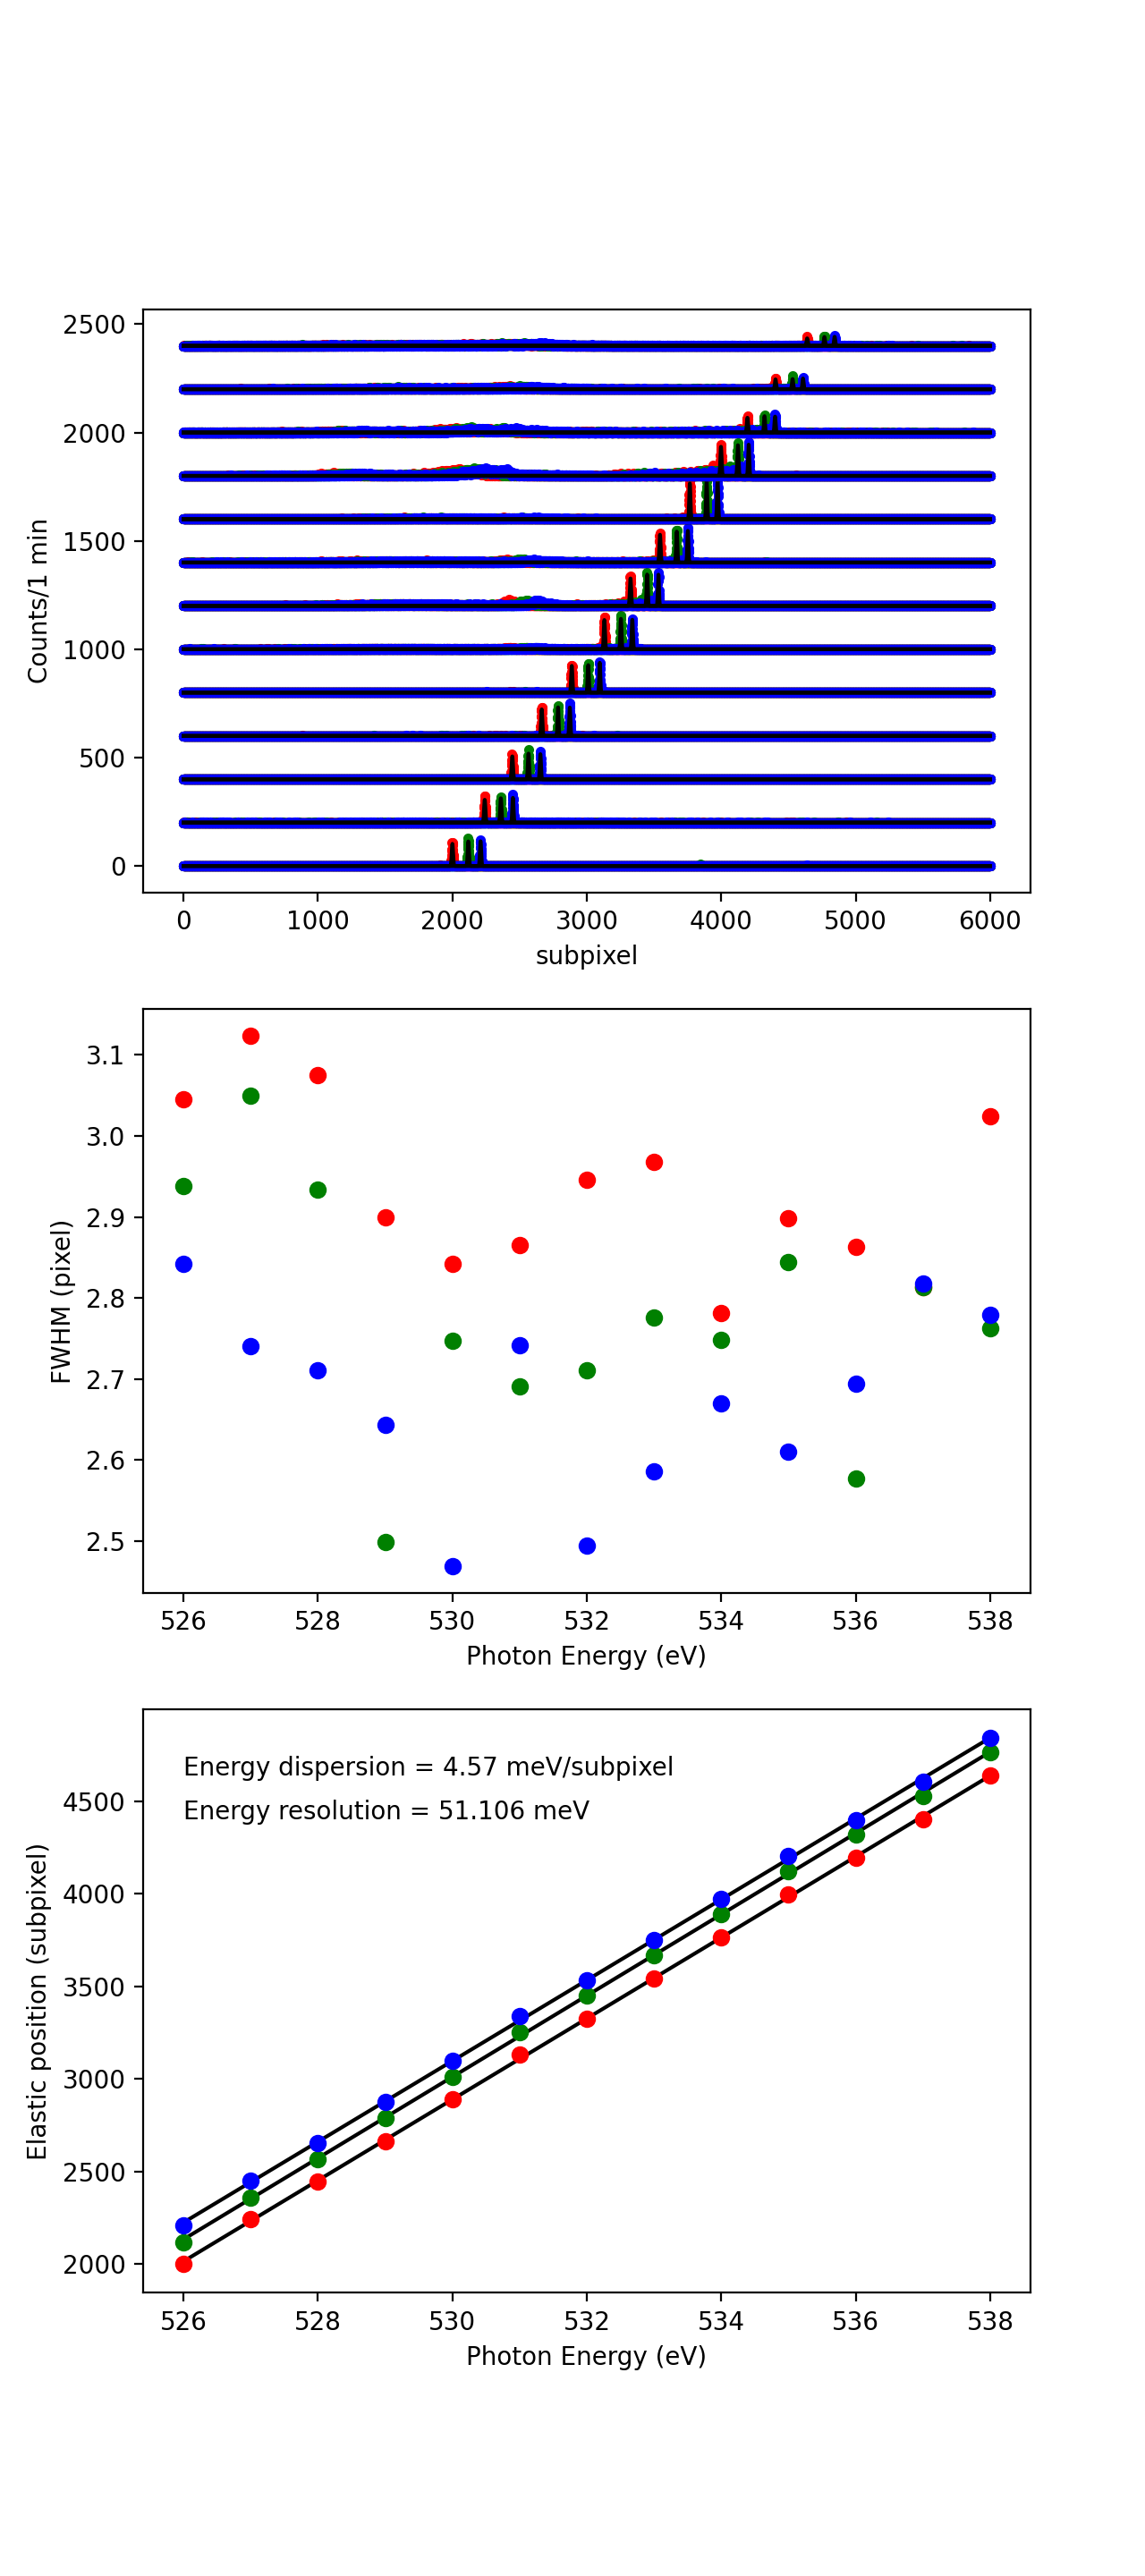

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6.4, 4.8*3))

fwhm1 = []
fwhm2 = []
fwhm3 = []
center1 = []
center2 = []
center3 = []
energy = []
energy_array = np.array([])

for i, s in enumerate(scans):
    en, [ccd1, ccd2, ccd3] = getdata(s)
    [mu1, sig1, amp1, mu2, sig2, amp2, mu3, sig3, amp3] = getdatafit(ccd1, ccd2, ccd3)

    offset = 200
    xdata = np.arange(len(ccd1))

    ax1.plot(xdata, ccd1 + offset * i, marker='.', color="r")
    ax1.plot(xdata, ccd2 + offset * i, marker='.', color="g")
    ax1.plot(xdata, ccd3 + offset * i, marker='.', color="b")

    ax1.plot(xdata, gaussian_norm(xdata, mu1, sig1, amp1) + offset * i, '-', color="black")
    ax1.plot(xdata, gaussian_norm(xdata, mu2, sig2, amp2) + offset * i, '-', color="black")
    ax1.plot(xdata, gaussian_norm(xdata, mu3, sig3, amp3) + offset * i, '-', color="black")

    ax2.plot(np.mean(en), sig1 * 2.355 / 4, 'o', color="r")
    ax2.plot(np.mean(en), sig2 * 2.355 / 4, 'o', color="g")
    ax2.plot(np.mean(en), sig3 * 2.355 / 4, 'o', color="b")

    energy.append(round(np.mean(en),2))
    fwhm1.append(sig1 * 2.355)
    center1.append(mu1)
    fwhm2.append(sig2 * 2.355)
    center2.append(mu2)
    fwhm3.append(sig3 * 2.355)
    center3.append(mu3)
    energy_array = np.concatenate([energy_array, en])

ax1.set(xlabel='subpixel')
ax1.set(ylabel='Counts/1 min')

ax2.set(xlabel='Photon Energy (eV)')
ax2.set(ylabel='FWHM (pixel)')

[myslope1, myinter1] = np.polyfit(energy, center1, 1)
[myslope2, myinter2] = np.polyfit(energy, center2, 1)
[myslope3, myinter3] = np.polyfit(energy, center3, 1)
energypersubpixel = 3.0 / (myslope1 + myslope2 + myslope3)
xplot = np.linspace(np.min(energy), np.max(energy), 100)

ax3.errorbar(energy, center1, yerr=fwhm1, xerr=None, linewidth=0, marker="o", color="r")
ax3.errorbar(energy, center2, yerr=fwhm2, xerr=None, linewidth=0, marker="o", color="g")
ax3.errorbar(energy, center3, yerr=fwhm3, xerr=None, linewidth=0, marker="o", color="b")

ax3.plot(xplot, myslope1 * xplot + myinter1, color='black')
ax3.plot(xplot, myslope2 * xplot + myinter2, color='black')
ax3.plot(xplot, myslope3 * xplot + myinter3, color='black')

ax3.annotate('Energy dispersion = ' + str(round(energypersubpixel * 1000, 3)) + ' meV/subpixel',
             xy=(energy[0], center1[-1]))
ax3.annotate('Energy resolution = ' + str(round(np.mean(fwhm1 + fwhm2 + fwhm3) * energypersubpixel * 1000, 3)) + ' meV',
             xy=(energy[0], center1[-2]))

ax3.set(xlabel='Photon Energy (eV)')
ax3.set(ylabel='Elastic position (subpixel)')

fig.savefig(str(today) + '_' + base + '_' + 'slope.png', dpi=600)
plt.show()



In [5]:
[myslope1, myinter1] = np.polyfit(center1, energy, 1)
[myslope2, myinter2] = np.polyfit(center2, energy, 1)
[myslope3, myinter3] = np.polyfit(center3, energy, 1)

print(f"elastic line function : [ {(myslope1+myslope2+myslope3)/3:.6e} , {myinter2:.6e} ]")

elastic line function : [ 4.569420e-03 , 5.162874e+02 ]


<IPython.core.display.Javascript object>


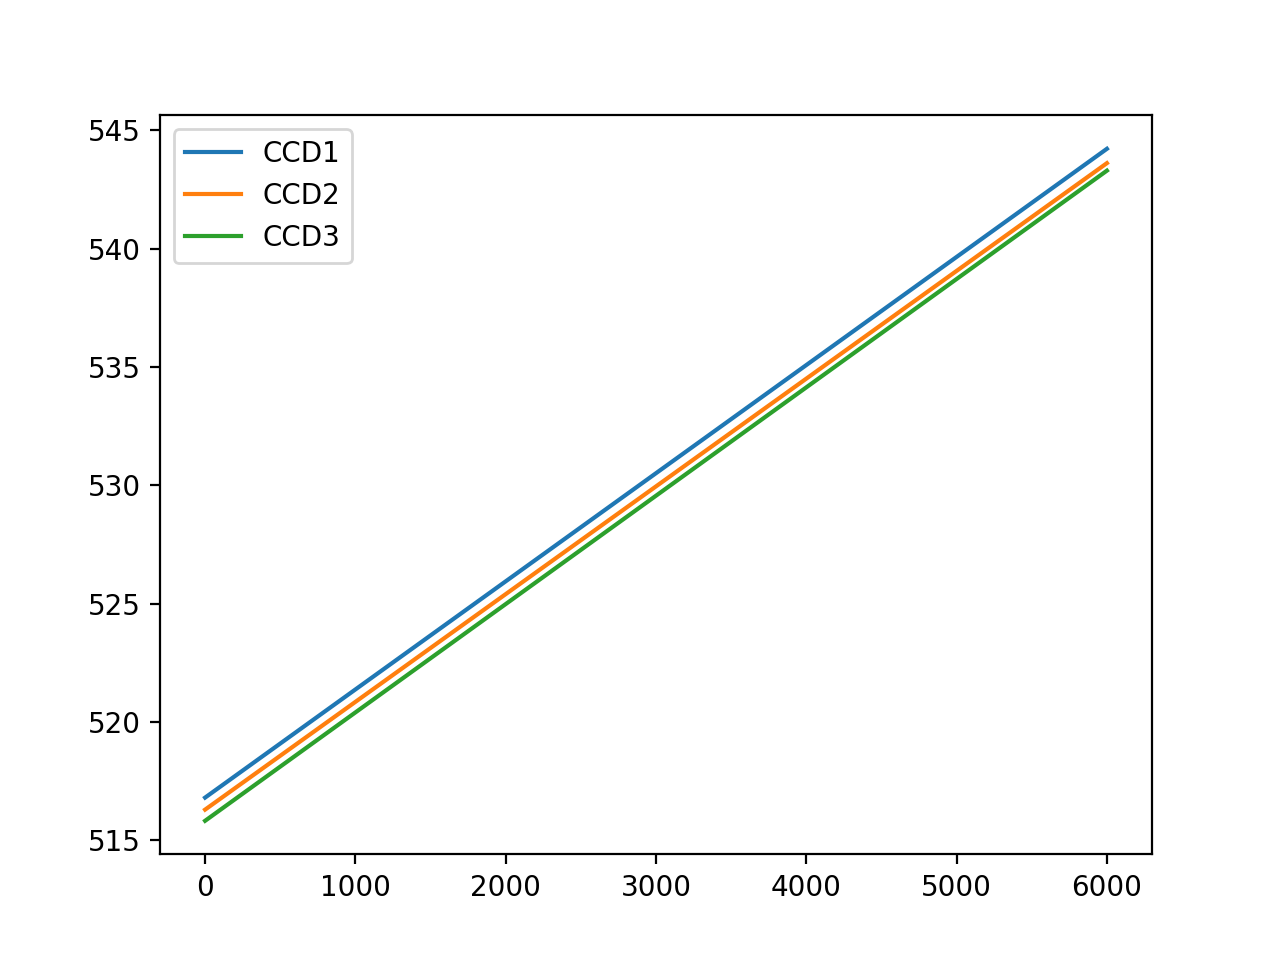

In [9]:
X = np.array([0, 6000])
Y1 = X * myslope1 + myinter1
Y2 = X * myslope2 + myinter2
Y3 = X * myslope3 + myinter3

plt.figure()
plt.plot(X,Y1,label='CCD1')
plt.plot(X,Y2,label='CCD2')
plt.plot(X,Y3,label='CCD3')
plt.legend()

<IPython.core.display.Javascript object>


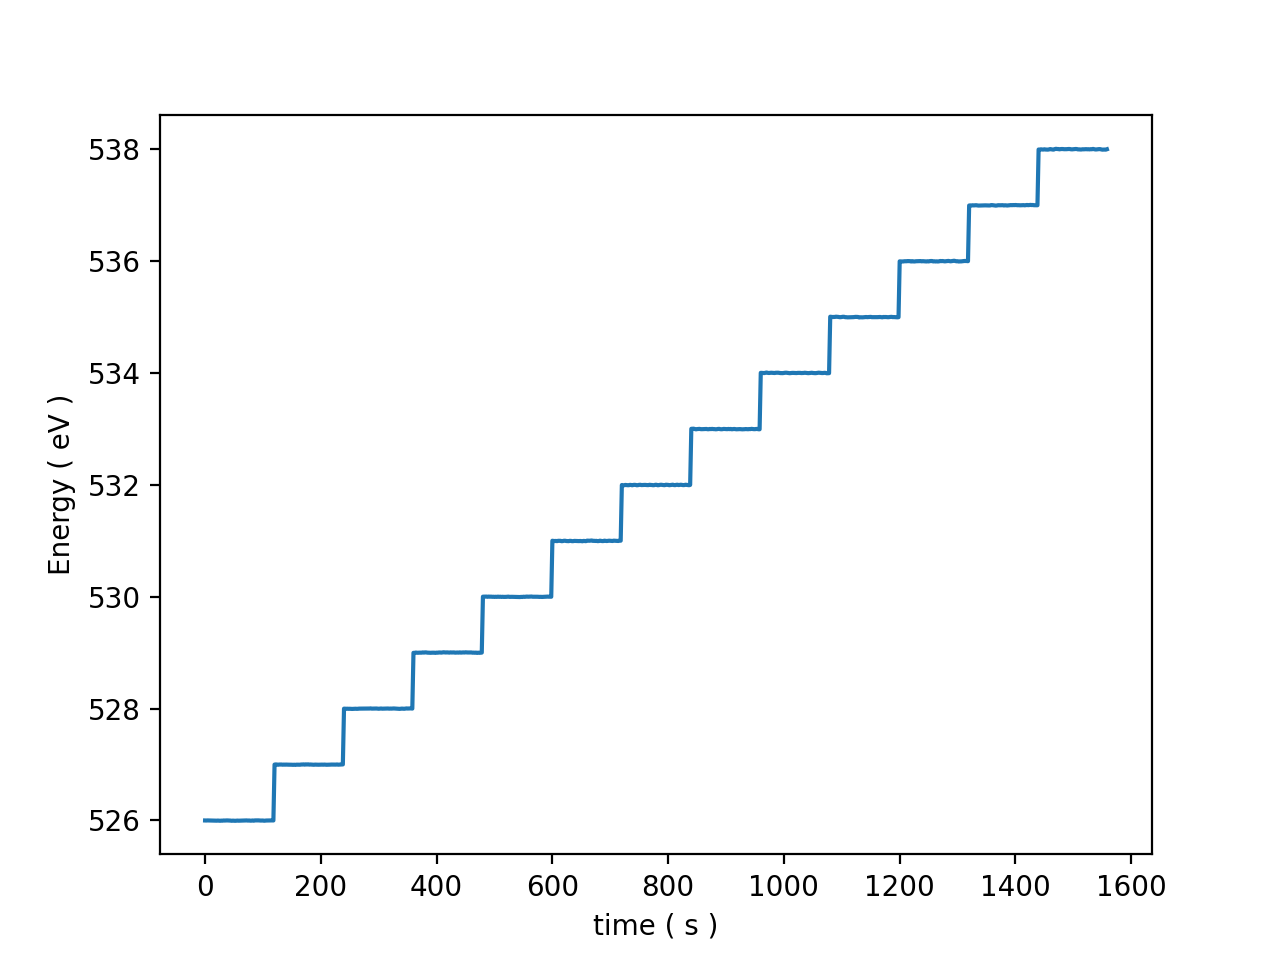

Text(0, 0.5, 'Energy ( eV )')

In [7]:
# scans = range(17,28)

# energy_array = []

# for i, s in enumerate(scans):
#     try:
#         en, [ccd1, ccd2, ccd3] = getdata(s)
#         energy_array = np.concatenate([energy_array,en])
#     except:
#         pass

plt.figure()
time_array=np.arange(0,len(energy_array)*2,2)
plt.plot(time_array,energy_array)
plt.xlabel('time ( s )')
plt.ylabel('Energy ( eV )')

# np.savetxt('mono_Oxygen.txt',np.transpose([time_array,energy_array]),fmt='%.18e', delimiter='\t', newline='\n',header='time(s)\tenergy(eV)',comments='# ')